In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

%matplotlib inline  

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Data Import

In [2]:
data_path = '../data/'
train_input_filename = 'train_input.csv'
train_output_filename = 'train_output.csv'

raw_inputdata = pd.read_csv(data_path+train_input_filename)
raw_outputdata = pd.read_csv(data_path+train_output_filename)

# Data Analysis

## Sneak peek

In [3]:
raw_inputdata['conversation'][20]

"<speaker_1> kesler accuses vancouver media of making up stories , throwing people under the bus prohockeytalk . nbcsports . com </s> <speaker_2> i certainly can 't say he 's wrong . the media here is atrocious , canucks could run an <number> - <number> season and win the cup in <number> games and the media would still drum up some sort of controversy somewhere . </s> <speaker_3> canuckleheads </s> </d>\n"

observations: 
1. Every entery contains multiple speakers
2. Each speaker is delimited by <!speaker> ... <!/s> tags.
3. Each entry ends with a newline character 
4. There are some <!number> tags. Looks like the numbers are replaced with these tags.
5. The user handles are preceeded by @ symbol
6. There are .com and .org website entries interspaced within conversations
7. There are some <!/d> tags towards the end just before newline

## Number of Classes

In [4]:
classes = raw_outputdata['category'].unique()
classes

array(['news', 'nfl', 'soccer', 'movies', 'politics', 'hockey', 'nba',
       'worldnews'], dtype=object)

So there are 8 categories

## Training Size

In [5]:
raw_outputdata.shape[0]

165000

## Training Size per Class

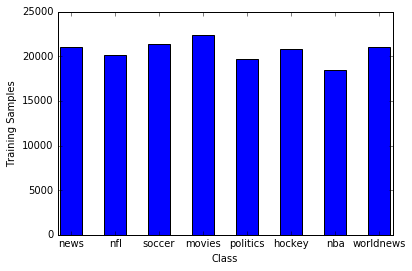

In [6]:
instances = [raw_outputdata[raw_outputdata['category'] == i].shape[0] for i in raw_outputdata['category'].unique()]

ind = np.linspace(1,24,8)

plt.bar(ind, instances, 1.7, align = 'center')
plt.xticks(ind, classes)
plt.ylabel('Training Samples')
plt.xlabel('Class')

# Data Clean-up

Steps:
    1. Run the data cleanup python script

# Data Aggregation

In [142]:
class_features = []
class_features_freq = []
class_totalwords = []
class_uniquewords = []

class_features_100 = []
class_features_100_freq = []

for i in classes:
    class_words_id = []

    class_idx = raw_outputdata[raw_outputdata['category'] == i]['id']
    idx = iter(class_idx)

    with open('../git_ws/reddit-text-classifier/data/newfile.csv', 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        idx_curr = next(idx)
        for row in reader:
            if row[0] == str(idx_curr):
                class_words_id.append(row[1:])
                try:
                    idx_curr = next(idx)
                except StopIteration:
                    break
            
    class_words_df = pd.DataFrame([x for sublist in class_words_id for x in sublist], columns=['words']) 
    
    class_word_count = class_words_df['words'].value_counts()
    class_features.append(class_word_count.index.values)
    class_features_freq.append(class_word_count)
    class_totalwords.append(class_words_df.shape[0])
    class_uniquewords.append(class_word_count.shape[0])
    
    class_word_count_100 = class_word_count[:100]
    class_features_100.append(class_word_count_100.index.values)
    class_features_100_freq.append(class_word_count_100)
    
    print (str(class_words_df.shape[0]) + ' total words' + ' & ' + str(class_word_count.shape[0]) + ' unique words for ' + str(i))

481175 total words & 25250 unique words for news
423795 total words & 21077 unique words for nfl
417115 total words & 24861 unique words for soccer
449494 total words & 24384 unique words for movies
480398 total words & 22220 unique words for politics
402058 total words & 23305 unique words for hockey
363554 total words & 19338 unique words for nba
479658 total words & 26019 unique words for worldnews


### Creating Bag of Words

In [ ]:
from itertools import islice
import sys

features_100 = pd.DataFrame([x for sublist in class_features_100 for x in sublist], columns=['features'])['features'].unique()

train_size = raw_inputdata.shape[0]
feature_len = len(features_100)

bag_of_words = np.zeros((train_size, feature_len), dtype=int)

row_idx = 0
with open('../git_ws/reddit-text-classifier/data/newfile.csv', 'rb') as in_csvfile:
    reader = csv.reader(in_csvfile, delimiter=',')
    
    with open('../data/bag_of_words_100.csv', 'wb') as out_csvfile:
        writer = csv.writer(out_csvfile, quoting = csv.QUOTE_NONE, skipinitialspace = True, delimiter = ' ', escapechar = ' ')
        
        for row in islice(reader, 1, None):
            #occurance = np.zeros((1, len(features_100)), dtype = int)
            sys.stdout.write("\r" + 'Analysing ' + str(row[0]) + ' out of ' + str(train_size))
            sys.stdout.flush()
            for word in row[1:]:
                
                idx = np.where(features_100 == word)
                
                if idx[0]:  bag_of_words[row_idx,idx[0][0]] += 1
                else:       continue
                    
            writer.writerow(bag_of_words[row_idx,:].tolist())
            row_idx += 1


Analysing 164999 out of 165000

# Saving Data

In [127]:
import csv

with open('../data/class_labels.csv', 'wb') as csvfile:
    wr = csv.writer(csvfile)
    wr.writerow(classes)

with open('../data/class_words.csv', 'wb') as csvfile:
    wr = csv.writer(csvfile)
    for i in range(len(class_features)):
        wr.writerow(class_features[i])

with open('../data/class_word_count.csv', 'wb') as csvfile:
    wr = csv.writer(csvfile)
    for i in range(len(class_features_freq)):
        wr.writerow(class_features_freq[i])
            
with open('../data/class_stats.csv', 'wb') as csvfile:
    wr = csv.writer(csvfile)
    wr.writerow(np.hstack((['stat_type'], classes)))
    wr.writerow(['totalwords'] + class_totalwords)
    wr.writerow(['uniquewords'] + class_uniquewords)
    
with open('../data/features.csv', 'wb') as csvfile:
    wr = csv.writer(csvfile)
    wr.writerow(features)
    
with open('../data/features_100.csv', 'wb') as csvfile:
    wr = csv.writer(csvfile)
    wr.writerow(features_100)